## 3.B. Explore -- Producer Modeling with Audio Data

After gathering and cleaning our data, we've realized that there are a good number of **producer values** missing from our Genius.com data. To account for this, we're going to explore the possibility of predicting producer based on our audio features, with the goal being to maximize the completeness of our dataset.

### Setup

In [131]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import time
import requests
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import lyricsgenius
import re
import sys
import spotipy
import spotipy.util as util
from sklearn.compose import ColumnTransformer, make_column_transformer
from pyjarowinkler import distance
import nltk

import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import time
import requests
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from gensim import corpora, models

import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt


import os
import sys
import librosa
import librosa.display as display
import IPython.display as ipd

from pydub import AudioSegment
from pydub.playback import play


In [132]:
df_all = pd.read_csv('cleaned_lyrics_and_audio_features.csv')

In [133]:
df_all.columns

Index(['album', 'artist', 'date', 'features', 'lyrics', 'producers', 'song',
       'artist_clean', 'album_name_clean', 'track_clean', 'acousticness',
       'album_id', 'album_name', 'artist_id', 'danceability', 'duration_ms',
       'energy', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'preview_url', 'speechiness', 'tempo_x', 'time_signature',
       'track_href', 'track_id', 'track_name', 'uri', 'valence', 'genres',
       'pop', 'follower', 'cleaned_lyrics', 'split_lyrics', 'number_lines',
       'track_unique_words_pct', 'track_unique_words', 'track_complexity',
       'track_total_words', 'artist_vocab_size', 'artist_vocab_complexity',
       'track_rhyme_density', 'cleaned_lyrics_for_sentiment',
       'sentiment_track_neg', 'sentiment_track_pos', 'sentiment_track_neu',
       'sentiment_track_comp', 'track_sad_words', 'track_angry_words',
       'track_joy_words', 'track_ant_words', 'track_trust_words',
       'track_fear_words', 'track_disgust_words

## Isolate to Audio Features and Deal with Nulls

In [134]:
df = df_all[['producers','danceability', 'energy','acousticness',
         'instrumentalness','key', 'liveness', 'loudness', 'tempo_y',
        'chroma_stft', 'spec_cent', 'spec_bw', 'rolloff', 'zcr', 'mfcc']]

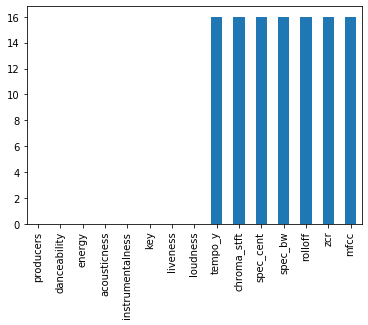

In [135]:
df.isnull().sum().plot(kind='bar');

In [136]:
df.tempo_y = df.tempo_y.fillna(np.mean(df.tempo_y))
df.chroma_stft = df.chroma_stft.fillna(np.mean(df.chroma_stft))
df.spec_cent = df.spec_cent.fillna(np.mean(df.spec_cent))
df.spec_bw = df.spec_bw.fillna(np.mean(df.spec_bw))
df.rolloff = df.rolloff.fillna(np.mean(df.rolloff))
df.zcr = df.zcr.fillna(np.mean(df.zcr))
df.mfcc = df.mfcc.fillna(np.mean(df.mfcc))

C:\Users\Owen\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [137]:
df.producers = df.producers.str.replace('[','').str.replace(']','').str.replace("'",'')

In [138]:
top_prod = list(df.producers.value_counts()[:30].index)[1:]

In [139]:
df = df[df.producers.isin(top_prod)]

## Encoding our Target

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

prod_list = df.producers
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(prod_list).reshape(-1, 1))

In [170]:
prod_list.shape

(2448,)

In [163]:
y.shape

(2448, 29)

In [141]:
X = df.drop(columns='producers')

In [142]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Train Test Split

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [144]:
X_train.shape

(1958, 14)

In [145]:
y_train.shape

(1958, 29)

## Neural Network for Audio Features

In [146]:
from keras import models
from keras import layers
from keras import regularizers
from keras.layers import Dropout


model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(layers.Dense(29, activation='softmax'))

In [147]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [148]:
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    verbose=2)

Train on 1958 samples, validate on 490 samples
Epoch 1/1000
 - 0s - loss: 8.1783 - accuracy: 0.0358 - top_k_categorical_accuracy: 0.1706 - val_loss: 7.7633 - val_accuracy: 0.0408 - val_top_k_categorical_accuracy: 0.1857
Epoch 2/1000
 - 0s - loss: 7.4567 - accuracy: 0.0546 - top_k_categorical_accuracy: 0.2222 - val_loss: 7.0992 - val_accuracy: 0.0592 - val_top_k_categorical_accuracy: 0.2571
Epoch 3/1000
 - 0s - loss: 6.8332 - accuracy: 0.0756 - top_k_categorical_accuracy: 0.2855 - val_loss: 6.5273 - val_accuracy: 0.0898 - val_top_k_categorical_accuracy: 0.2980
Epoch 4/1000
 - 0s - loss: 6.2992 - accuracy: 0.0996 - top_k_categorical_accuracy: 0.3003 - val_loss: 6.0361 - val_accuracy: 0.1102 - val_top_k_categorical_accuracy: 0.2959
Epoch 5/1000
 - 0s - loss: 5.8411 - accuracy: 0.1016 - top_k_categorical_accuracy: 0.3187 - val_loss: 5.6155 - val_accuracy: 0.1163 - val_top_k_categorical_accuracy: 0.3367
Epoch 6/1000
 - 0s - loss: 5.4486 - accuracy: 0.1021 - top_k_categorical_accuracy: 0.333

Epoch 48/1000
 - 0s - loss: 2.9571 - accuracy: 0.1808 - top_k_categorical_accuracy: 0.5174 - val_loss: 2.9863 - val_accuracy: 0.1796 - val_top_k_categorical_accuracy: 0.5020
Epoch 49/1000
 - 0s - loss: 2.9521 - accuracy: 0.1808 - top_k_categorical_accuracy: 0.5189 - val_loss: 2.9779 - val_accuracy: 0.1796 - val_top_k_categorical_accuracy: 0.5082
Epoch 50/1000
 - 0s - loss: 2.9466 - accuracy: 0.1813 - top_k_categorical_accuracy: 0.5194 - val_loss: 2.9752 - val_accuracy: 0.1816 - val_top_k_categorical_accuracy: 0.4980
Epoch 51/1000
 - 0s - loss: 2.9421 - accuracy: 0.1834 - top_k_categorical_accuracy: 0.5199 - val_loss: 2.9671 - val_accuracy: 0.1898 - val_top_k_categorical_accuracy: 0.5000
Epoch 52/1000
 - 0s - loss: 2.9360 - accuracy: 0.1864 - top_k_categorical_accuracy: 0.5266 - val_loss: 2.9684 - val_accuracy: 0.1918 - val_top_k_categorical_accuracy: 0.4959
Epoch 53/1000
 - 0s - loss: 2.9306 - accuracy: 0.1864 - top_k_categorical_accuracy: 0.5220 - val_loss: 2.9627 - val_accuracy: 0.19

Epoch 96/1000
 - 0s - loss: 2.8177 - accuracy: 0.2084 - top_k_categorical_accuracy: 0.5511 - val_loss: 2.8756 - val_accuracy: 0.1714 - val_top_k_categorical_accuracy: 0.5347
Epoch 97/1000
 - 0s - loss: 2.8219 - accuracy: 0.2114 - top_k_categorical_accuracy: 0.5613 - val_loss: 2.8787 - val_accuracy: 0.1878 - val_top_k_categorical_accuracy: 0.5388
Epoch 98/1000
 - 0s - loss: 2.8172 - accuracy: 0.2135 - top_k_categorical_accuracy: 0.5531 - val_loss: 2.8800 - val_accuracy: 0.1918 - val_top_k_categorical_accuracy: 0.5347
Epoch 99/1000
 - 0s - loss: 2.8149 - accuracy: 0.2084 - top_k_categorical_accuracy: 0.5613 - val_loss: 2.8716 - val_accuracy: 0.1816 - val_top_k_categorical_accuracy: 0.5265
Epoch 100/1000
 - 0s - loss: 2.8086 - accuracy: 0.2104 - top_k_categorical_accuracy: 0.5618 - val_loss: 2.8695 - val_accuracy: 0.1918 - val_top_k_categorical_accuracy: 0.5408
Epoch 101/1000
 - 0s - loss: 2.8093 - accuracy: 0.2125 - top_k_categorical_accuracy: 0.5623 - val_loss: 2.8820 - val_accuracy: 0.

Epoch 143/1000
 - 0s - loss: 2.7628 - accuracy: 0.2196 - top_k_categorical_accuracy: 0.5710 - val_loss: 2.8446 - val_accuracy: 0.1694 - val_top_k_categorical_accuracy: 0.5245
Epoch 144/1000
 - 0s - loss: 2.7625 - accuracy: 0.2176 - top_k_categorical_accuracy: 0.5695 - val_loss: 2.8531 - val_accuracy: 0.1714 - val_top_k_categorical_accuracy: 0.5163
Epoch 145/1000
 - 0s - loss: 2.7634 - accuracy: 0.2181 - top_k_categorical_accuracy: 0.5771 - val_loss: 2.8454 - val_accuracy: 0.1816 - val_top_k_categorical_accuracy: 0.5306
Epoch 146/1000
 - 0s - loss: 2.7550 - accuracy: 0.2211 - top_k_categorical_accuracy: 0.5741 - val_loss: 2.8415 - val_accuracy: 0.1816 - val_top_k_categorical_accuracy: 0.5327
Epoch 147/1000
 - 0s - loss: 2.7617 - accuracy: 0.2191 - top_k_categorical_accuracy: 0.5674 - val_loss: 2.8489 - val_accuracy: 0.1878 - val_top_k_categorical_accuracy: 0.5347
Epoch 148/1000
 - 0s - loss: 2.7590 - accuracy: 0.2206 - top_k_categorical_accuracy: 0.5781 - val_loss: 2.8374 - val_accuracy

Epoch 190/1000
 - 0s - loss: 2.7251 - accuracy: 0.2273 - top_k_categorical_accuracy: 0.5776 - val_loss: 2.8258 - val_accuracy: 0.1714 - val_top_k_categorical_accuracy: 0.5347
Epoch 191/1000
 - 0s - loss: 2.7266 - accuracy: 0.2257 - top_k_categorical_accuracy: 0.5838 - val_loss: 2.8292 - val_accuracy: 0.1673 - val_top_k_categorical_accuracy: 0.5347
Epoch 192/1000
 - 0s - loss: 2.7238 - accuracy: 0.2278 - top_k_categorical_accuracy: 0.5858 - val_loss: 2.8396 - val_accuracy: 0.1714 - val_top_k_categorical_accuracy: 0.5306
Epoch 193/1000
 - 0s - loss: 2.7256 - accuracy: 0.2288 - top_k_categorical_accuracy: 0.5812 - val_loss: 2.8268 - val_accuracy: 0.1776 - val_top_k_categorical_accuracy: 0.5286
Epoch 194/1000
 - 0s - loss: 2.7219 - accuracy: 0.2293 - top_k_categorical_accuracy: 0.5868 - val_loss: 2.8316 - val_accuracy: 0.1816 - val_top_k_categorical_accuracy: 0.5327
Epoch 195/1000
 - 0s - loss: 2.7248 - accuracy: 0.2303 - top_k_categorical_accuracy: 0.5817 - val_loss: 2.8226 - val_accuracy

Epoch 237/1000
 - 0s - loss: 2.6995 - accuracy: 0.2354 - top_k_categorical_accuracy: 0.6006 - val_loss: 2.8185 - val_accuracy: 0.1857 - val_top_k_categorical_accuracy: 0.5388
Epoch 238/1000
 - 0s - loss: 2.6946 - accuracy: 0.2329 - top_k_categorical_accuracy: 0.5996 - val_loss: 2.8147 - val_accuracy: 0.1776 - val_top_k_categorical_accuracy: 0.5469
Epoch 239/1000
 - 0s - loss: 2.6937 - accuracy: 0.2354 - top_k_categorical_accuracy: 0.6006 - val_loss: 2.8071 - val_accuracy: 0.1837 - val_top_k_categorical_accuracy: 0.5408
Epoch 240/1000
 - 0s - loss: 2.6920 - accuracy: 0.2283 - top_k_categorical_accuracy: 0.5930 - val_loss: 2.8109 - val_accuracy: 0.1837 - val_top_k_categorical_accuracy: 0.5510
Epoch 241/1000
 - 0s - loss: 2.6956 - accuracy: 0.2324 - top_k_categorical_accuracy: 0.5935 - val_loss: 2.8046 - val_accuracy: 0.1857 - val_top_k_categorical_accuracy: 0.5449
Epoch 242/1000
 - 0s - loss: 2.6926 - accuracy: 0.2344 - top_k_categorical_accuracy: 0.5986 - val_loss: 2.8054 - val_accuracy

Epoch 284/1000
 - 0s - loss: 2.6711 - accuracy: 0.2406 - top_k_categorical_accuracy: 0.6047 - val_loss: 2.7900 - val_accuracy: 0.1816 - val_top_k_categorical_accuracy: 0.5531
Epoch 285/1000
 - 0s - loss: 2.6647 - accuracy: 0.2406 - top_k_categorical_accuracy: 0.6073 - val_loss: 2.7882 - val_accuracy: 0.1898 - val_top_k_categorical_accuracy: 0.5408
Epoch 286/1000
 - 0s - loss: 2.6710 - accuracy: 0.2457 - top_k_categorical_accuracy: 0.6129 - val_loss: 2.7917 - val_accuracy: 0.1939 - val_top_k_categorical_accuracy: 0.5551
Epoch 287/1000
 - 0s - loss: 2.6693 - accuracy: 0.2365 - top_k_categorical_accuracy: 0.6144 - val_loss: 2.7957 - val_accuracy: 0.1898 - val_top_k_categorical_accuracy: 0.5490
Epoch 288/1000
 - 0s - loss: 2.6715 - accuracy: 0.2411 - top_k_categorical_accuracy: 0.6067 - val_loss: 2.7942 - val_accuracy: 0.2082 - val_top_k_categorical_accuracy: 0.5469
Epoch 289/1000
 - 0s - loss: 2.6676 - accuracy: 0.2324 - top_k_categorical_accuracy: 0.6067 - val_loss: 2.7870 - val_accuracy

Epoch 331/1000
 - 0s - loss: 2.6323 - accuracy: 0.2569 - top_k_categorical_accuracy: 0.6287 - val_loss: 2.7704 - val_accuracy: 0.2163 - val_top_k_categorical_accuracy: 0.5735
Epoch 332/1000
 - 0s - loss: 2.6353 - accuracy: 0.2594 - top_k_categorical_accuracy: 0.6302 - val_loss: 2.7539 - val_accuracy: 0.2082 - val_top_k_categorical_accuracy: 0.5816
Epoch 333/1000
 - 0s - loss: 2.6290 - accuracy: 0.2600 - top_k_categorical_accuracy: 0.6190 - val_loss: 2.7562 - val_accuracy: 0.2061 - val_top_k_categorical_accuracy: 0.5918
Epoch 334/1000
 - 0s - loss: 2.6357 - accuracy: 0.2589 - top_k_categorical_accuracy: 0.6251 - val_loss: 2.7557 - val_accuracy: 0.2102 - val_top_k_categorical_accuracy: 0.5735
Epoch 335/1000
 - 0s - loss: 2.6259 - accuracy: 0.2600 - top_k_categorical_accuracy: 0.6205 - val_loss: 2.7658 - val_accuracy: 0.2041 - val_top_k_categorical_accuracy: 0.5776
Epoch 336/1000
 - 0s - loss: 2.6224 - accuracy: 0.2666 - top_k_categorical_accuracy: 0.6287 - val_loss: 2.7493 - val_accuracy

Epoch 378/1000
 - 0s - loss: 2.5942 - accuracy: 0.2778 - top_k_categorical_accuracy: 0.6461 - val_loss: 2.7290 - val_accuracy: 0.2102 - val_top_k_categorical_accuracy: 0.5714
Epoch 379/1000
 - 0s - loss: 2.5924 - accuracy: 0.2692 - top_k_categorical_accuracy: 0.6430 - val_loss: 2.7237 - val_accuracy: 0.2245 - val_top_k_categorical_accuracy: 0.5612
Epoch 380/1000
 - 0s - loss: 2.5992 - accuracy: 0.2686 - top_k_categorical_accuracy: 0.6374 - val_loss: 2.7349 - val_accuracy: 0.2204 - val_top_k_categorical_accuracy: 0.5735
Epoch 381/1000
 - 0s - loss: 2.5949 - accuracy: 0.2773 - top_k_categorical_accuracy: 0.6394 - val_loss: 2.7379 - val_accuracy: 0.2143 - val_top_k_categorical_accuracy: 0.5755
Epoch 382/1000
 - 0s - loss: 2.5861 - accuracy: 0.2732 - top_k_categorical_accuracy: 0.6420 - val_loss: 2.7336 - val_accuracy: 0.2286 - val_top_k_categorical_accuracy: 0.5776
Epoch 383/1000
 - 0s - loss: 2.5855 - accuracy: 0.2717 - top_k_categorical_accuracy: 0.6384 - val_loss: 2.7268 - val_accuracy

Epoch 425/1000
 - 0s - loss: 2.5647 - accuracy: 0.2722 - top_k_categorical_accuracy: 0.6486 - val_loss: 2.7220 - val_accuracy: 0.2143 - val_top_k_categorical_accuracy: 0.5980
Epoch 426/1000
 - 0s - loss: 2.5649 - accuracy: 0.2732 - top_k_categorical_accuracy: 0.6486 - val_loss: 2.7095 - val_accuracy: 0.2163 - val_top_k_categorical_accuracy: 0.5898
Epoch 427/1000
 - 0s - loss: 2.5603 - accuracy: 0.2707 - top_k_categorical_accuracy: 0.6486 - val_loss: 2.7140 - val_accuracy: 0.2327 - val_top_k_categorical_accuracy: 0.5918
Epoch 428/1000
 - 0s - loss: 2.5650 - accuracy: 0.2794 - top_k_categorical_accuracy: 0.6496 - val_loss: 2.7070 - val_accuracy: 0.2306 - val_top_k_categorical_accuracy: 0.5796
Epoch 429/1000
 - 0s - loss: 2.5589 - accuracy: 0.2773 - top_k_categorical_accuracy: 0.6542 - val_loss: 2.6996 - val_accuracy: 0.2306 - val_top_k_categorical_accuracy: 0.5959
Epoch 430/1000
 - 0s - loss: 2.5578 - accuracy: 0.2773 - top_k_categorical_accuracy: 0.6507 - val_loss: 2.7109 - val_accuracy

Epoch 472/1000
 - 0s - loss: 2.5382 - accuracy: 0.2829 - top_k_categorical_accuracy: 0.6517 - val_loss: 2.6885 - val_accuracy: 0.2408 - val_top_k_categorical_accuracy: 0.5939
Epoch 473/1000
 - 0s - loss: 2.5338 - accuracy: 0.2901 - top_k_categorical_accuracy: 0.6578 - val_loss: 2.7059 - val_accuracy: 0.2245 - val_top_k_categorical_accuracy: 0.6000
Epoch 474/1000
 - 0s - loss: 2.5370 - accuracy: 0.2840 - top_k_categorical_accuracy: 0.6542 - val_loss: 2.6901 - val_accuracy: 0.2286 - val_top_k_categorical_accuracy: 0.5939
Epoch 475/1000
 - 0s - loss: 2.5403 - accuracy: 0.3008 - top_k_categorical_accuracy: 0.6553 - val_loss: 2.6909 - val_accuracy: 0.2490 - val_top_k_categorical_accuracy: 0.5878
Epoch 476/1000
 - 0s - loss: 2.5360 - accuracy: 0.2804 - top_k_categorical_accuracy: 0.6553 - val_loss: 2.6848 - val_accuracy: 0.2347 - val_top_k_categorical_accuracy: 0.5980
Epoch 477/1000
 - 0s - loss: 2.5352 - accuracy: 0.2870 - top_k_categorical_accuracy: 0.6563 - val_loss: 2.6809 - val_accuracy

Epoch 519/1000
 - 0s - loss: 2.5079 - accuracy: 0.2916 - top_k_categorical_accuracy: 0.6650 - val_loss: 2.6797 - val_accuracy: 0.2327 - val_top_k_categorical_accuracy: 0.6082
Epoch 520/1000
 - 0s - loss: 2.5135 - accuracy: 0.2932 - top_k_categorical_accuracy: 0.6655 - val_loss: 2.6761 - val_accuracy: 0.2490 - val_top_k_categorical_accuracy: 0.6061
Epoch 521/1000
 - 0s - loss: 2.5100 - accuracy: 0.2957 - top_k_categorical_accuracy: 0.6650 - val_loss: 2.6759 - val_accuracy: 0.2510 - val_top_k_categorical_accuracy: 0.5959
Epoch 522/1000
 - 0s - loss: 2.5120 - accuracy: 0.2937 - top_k_categorical_accuracy: 0.6655 - val_loss: 2.6653 - val_accuracy: 0.2469 - val_top_k_categorical_accuracy: 0.6041
Epoch 523/1000
 - 0s - loss: 2.5086 - accuracy: 0.2926 - top_k_categorical_accuracy: 0.6609 - val_loss: 2.6874 - val_accuracy: 0.2367 - val_top_k_categorical_accuracy: 0.5959
Epoch 524/1000
 - 0s - loss: 2.5162 - accuracy: 0.2916 - top_k_categorical_accuracy: 0.6578 - val_loss: 2.6679 - val_accuracy

Epoch 566/1000
 - 0s - loss: 2.4825 - accuracy: 0.2947 - top_k_categorical_accuracy: 0.6752 - val_loss: 2.6616 - val_accuracy: 0.2408 - val_top_k_categorical_accuracy: 0.6061
Epoch 567/1000
 - 0s - loss: 2.4822 - accuracy: 0.3008 - top_k_categorical_accuracy: 0.6716 - val_loss: 2.6578 - val_accuracy: 0.2429 - val_top_k_categorical_accuracy: 0.6224
Epoch 568/1000
 - 0s - loss: 2.4845 - accuracy: 0.2998 - top_k_categorical_accuracy: 0.6731 - val_loss: 2.6562 - val_accuracy: 0.2347 - val_top_k_categorical_accuracy: 0.6041
Epoch 569/1000
 - 0s - loss: 2.4866 - accuracy: 0.3003 - top_k_categorical_accuracy: 0.6691 - val_loss: 2.6683 - val_accuracy: 0.2367 - val_top_k_categorical_accuracy: 0.6061
Epoch 570/1000
 - 0s - loss: 2.4812 - accuracy: 0.2983 - top_k_categorical_accuracy: 0.6706 - val_loss: 2.6521 - val_accuracy: 0.2245 - val_top_k_categorical_accuracy: 0.6265
Epoch 571/1000
 - 0s - loss: 2.4799 - accuracy: 0.2952 - top_k_categorical_accuracy: 0.6731 - val_loss: 2.6564 - val_accuracy

Epoch 613/1000
 - 0s - loss: 2.4661 - accuracy: 0.3069 - top_k_categorical_accuracy: 0.6788 - val_loss: 2.6404 - val_accuracy: 0.2449 - val_top_k_categorical_accuracy: 0.6204
Epoch 614/1000
 - 0s - loss: 2.4693 - accuracy: 0.2993 - top_k_categorical_accuracy: 0.6813 - val_loss: 2.6555 - val_accuracy: 0.2347 - val_top_k_categorical_accuracy: 0.6245
Epoch 615/1000
 - 0s - loss: 2.4680 - accuracy: 0.2937 - top_k_categorical_accuracy: 0.6864 - val_loss: 2.6656 - val_accuracy: 0.2306 - val_top_k_categorical_accuracy: 0.6286
Epoch 616/1000
 - 0s - loss: 2.4604 - accuracy: 0.3023 - top_k_categorical_accuracy: 0.6808 - val_loss: 2.6371 - val_accuracy: 0.2347 - val_top_k_categorical_accuracy: 0.6367
Epoch 617/1000
 - 0s - loss: 2.4583 - accuracy: 0.3034 - top_k_categorical_accuracy: 0.6859 - val_loss: 2.6429 - val_accuracy: 0.2347 - val_top_k_categorical_accuracy: 0.6224
Epoch 618/1000
 - 0s - loss: 2.4634 - accuracy: 0.3008 - top_k_categorical_accuracy: 0.6701 - val_loss: 2.6415 - val_accuracy

Epoch 660/1000
 - 0s - loss: 2.4453 - accuracy: 0.3080 - top_k_categorical_accuracy: 0.6808 - val_loss: 2.6429 - val_accuracy: 0.2449 - val_top_k_categorical_accuracy: 0.6286
Epoch 661/1000
 - 0s - loss: 2.4473 - accuracy: 0.3141 - top_k_categorical_accuracy: 0.6854 - val_loss: 2.6391 - val_accuracy: 0.2490 - val_top_k_categorical_accuracy: 0.6347
Epoch 662/1000
 - 0s - loss: 2.4399 - accuracy: 0.3049 - top_k_categorical_accuracy: 0.6925 - val_loss: 2.6469 - val_accuracy: 0.2429 - val_top_k_categorical_accuracy: 0.6347
Epoch 663/1000
 - 0s - loss: 2.4423 - accuracy: 0.3023 - top_k_categorical_accuracy: 0.6839 - val_loss: 2.6479 - val_accuracy: 0.2429 - val_top_k_categorical_accuracy: 0.6347
Epoch 664/1000
 - 0s - loss: 2.4403 - accuracy: 0.3080 - top_k_categorical_accuracy: 0.6890 - val_loss: 2.6341 - val_accuracy: 0.2408 - val_top_k_categorical_accuracy: 0.6367
Epoch 665/1000
 - 0s - loss: 2.4400 - accuracy: 0.3039 - top_k_categorical_accuracy: 0.6859 - val_loss: 2.6387 - val_accuracy

Epoch 707/1000
 - 0s - loss: 2.4245 - accuracy: 0.3085 - top_k_categorical_accuracy: 0.6966 - val_loss: 2.6393 - val_accuracy: 0.2388 - val_top_k_categorical_accuracy: 0.6429
Epoch 708/1000
 - 0s - loss: 2.4188 - accuracy: 0.3136 - top_k_categorical_accuracy: 0.6920 - val_loss: 2.6334 - val_accuracy: 0.2388 - val_top_k_categorical_accuracy: 0.6449
Epoch 709/1000
 - 0s - loss: 2.4228 - accuracy: 0.3110 - top_k_categorical_accuracy: 0.6961 - val_loss: 2.6344 - val_accuracy: 0.2408 - val_top_k_categorical_accuracy: 0.6408
Epoch 710/1000
 - 0s - loss: 2.4205 - accuracy: 0.3090 - top_k_categorical_accuracy: 0.6885 - val_loss: 2.6226 - val_accuracy: 0.2531 - val_top_k_categorical_accuracy: 0.6510
Epoch 711/1000
 - 0s - loss: 2.4286 - accuracy: 0.3141 - top_k_categorical_accuracy: 0.6910 - val_loss: 2.6333 - val_accuracy: 0.2327 - val_top_k_categorical_accuracy: 0.6429
Epoch 712/1000
 - 0s - loss: 2.4225 - accuracy: 0.3080 - top_k_categorical_accuracy: 0.6946 - val_loss: 2.6308 - val_accuracy

Epoch 754/1000
 - 0s - loss: 2.4085 - accuracy: 0.3110 - top_k_categorical_accuracy: 0.6941 - val_loss: 2.6288 - val_accuracy: 0.2408 - val_top_k_categorical_accuracy: 0.6347
Epoch 755/1000
 - 0s - loss: 2.4069 - accuracy: 0.3223 - top_k_categorical_accuracy: 0.6977 - val_loss: 2.6296 - val_accuracy: 0.2633 - val_top_k_categorical_accuracy: 0.6286
Epoch 756/1000
 - 0s - loss: 2.4176 - accuracy: 0.3161 - top_k_categorical_accuracy: 0.6936 - val_loss: 2.6325 - val_accuracy: 0.2592 - val_top_k_categorical_accuracy: 0.6265
Epoch 757/1000
 - 0s - loss: 2.4157 - accuracy: 0.3177 - top_k_categorical_accuracy: 0.7007 - val_loss: 2.6289 - val_accuracy: 0.2490 - val_top_k_categorical_accuracy: 0.6306
Epoch 758/1000
 - 0s - loss: 2.4108 - accuracy: 0.3243 - top_k_categorical_accuracy: 0.6931 - val_loss: 2.6221 - val_accuracy: 0.2429 - val_top_k_categorical_accuracy: 0.6367
Epoch 759/1000
 - 0s - loss: 2.4038 - accuracy: 0.3177 - top_k_categorical_accuracy: 0.6987 - val_loss: 2.6268 - val_accuracy

Epoch 801/1000
 - 0s - loss: 2.4070 - accuracy: 0.3233 - top_k_categorical_accuracy: 0.6987 - val_loss: 2.6389 - val_accuracy: 0.2612 - val_top_k_categorical_accuracy: 0.6245
Epoch 802/1000
 - 0s - loss: 2.3955 - accuracy: 0.3156 - top_k_categorical_accuracy: 0.7007 - val_loss: 2.6267 - val_accuracy: 0.2551 - val_top_k_categorical_accuracy: 0.6347
Epoch 803/1000
 - 0s - loss: 2.3952 - accuracy: 0.3248 - top_k_categorical_accuracy: 0.7002 - val_loss: 2.6244 - val_accuracy: 0.2510 - val_top_k_categorical_accuracy: 0.6408
Epoch 804/1000
 - 0s - loss: 2.3954 - accuracy: 0.3258 - top_k_categorical_accuracy: 0.6992 - val_loss: 2.6237 - val_accuracy: 0.2592 - val_top_k_categorical_accuracy: 0.6449
Epoch 805/1000
 - 0s - loss: 2.3961 - accuracy: 0.3197 - top_k_categorical_accuracy: 0.7074 - val_loss: 2.6288 - val_accuracy: 0.2490 - val_top_k_categorical_accuracy: 0.6429
Epoch 806/1000
 - 0s - loss: 2.3956 - accuracy: 0.3233 - top_k_categorical_accuracy: 0.7063 - val_loss: 2.6203 - val_accuracy

Epoch 848/1000
 - 0s - loss: 2.3883 - accuracy: 0.3248 - top_k_categorical_accuracy: 0.7140 - val_loss: 2.6289 - val_accuracy: 0.2571 - val_top_k_categorical_accuracy: 0.6327
Epoch 849/1000
 - 0s - loss: 2.3940 - accuracy: 0.3218 - top_k_categorical_accuracy: 0.7048 - val_loss: 2.6682 - val_accuracy: 0.2408 - val_top_k_categorical_accuracy: 0.6449
Epoch 850/1000
 - 0s - loss: 2.3948 - accuracy: 0.3223 - top_k_categorical_accuracy: 0.7074 - val_loss: 2.6343 - val_accuracy: 0.2571 - val_top_k_categorical_accuracy: 0.6388
Epoch 851/1000
 - 0s - loss: 2.3811 - accuracy: 0.3274 - top_k_categorical_accuracy: 0.7099 - val_loss: 2.6228 - val_accuracy: 0.2653 - val_top_k_categorical_accuracy: 0.6408
Epoch 852/1000
 - 0s - loss: 2.3836 - accuracy: 0.3233 - top_k_categorical_accuracy: 0.7028 - val_loss: 2.6365 - val_accuracy: 0.2449 - val_top_k_categorical_accuracy: 0.6449
Epoch 853/1000
 - 0s - loss: 2.3792 - accuracy: 0.3228 - top_k_categorical_accuracy: 0.7053 - val_loss: 2.6377 - val_accuracy

Epoch 895/1000
 - 0s - loss: 2.3859 - accuracy: 0.3238 - top_k_categorical_accuracy: 0.7089 - val_loss: 2.6409 - val_accuracy: 0.2510 - val_top_k_categorical_accuracy: 0.6449
Epoch 896/1000
 - 0s - loss: 2.3735 - accuracy: 0.3264 - top_k_categorical_accuracy: 0.7120 - val_loss: 2.6497 - val_accuracy: 0.2469 - val_top_k_categorical_accuracy: 0.6510
Epoch 897/1000
 - 0s - loss: 2.3712 - accuracy: 0.3258 - top_k_categorical_accuracy: 0.7120 - val_loss: 2.6331 - val_accuracy: 0.2653 - val_top_k_categorical_accuracy: 0.6388
Epoch 898/1000
 - 0s - loss: 2.3650 - accuracy: 0.3325 - top_k_categorical_accuracy: 0.7104 - val_loss: 2.6348 - val_accuracy: 0.2551 - val_top_k_categorical_accuracy: 0.6429
Epoch 899/1000
 - 0s - loss: 2.3734 - accuracy: 0.3253 - top_k_categorical_accuracy: 0.7120 - val_loss: 2.6306 - val_accuracy: 0.2571 - val_top_k_categorical_accuracy: 0.6429
Epoch 900/1000
 - 0s - loss: 2.3791 - accuracy: 0.3253 - top_k_categorical_accuracy: 0.7109 - val_loss: 2.6313 - val_accuracy

Epoch 942/1000
 - 0s - loss: 2.3591 - accuracy: 0.3361 - top_k_categorical_accuracy: 0.7125 - val_loss: 2.6185 - val_accuracy: 0.2633 - val_top_k_categorical_accuracy: 0.6429
Epoch 943/1000
 - 0s - loss: 2.3571 - accuracy: 0.3366 - top_k_categorical_accuracy: 0.7222 - val_loss: 2.6501 - val_accuracy: 0.2571 - val_top_k_categorical_accuracy: 0.6449
Epoch 944/1000
 - 0s - loss: 2.3620 - accuracy: 0.3335 - top_k_categorical_accuracy: 0.7186 - val_loss: 2.6336 - val_accuracy: 0.2633 - val_top_k_categorical_accuracy: 0.6449
Epoch 945/1000
 - 0s - loss: 2.3578 - accuracy: 0.3381 - top_k_categorical_accuracy: 0.7196 - val_loss: 2.6161 - val_accuracy: 0.2694 - val_top_k_categorical_accuracy: 0.6510
Epoch 946/1000
 - 0s - loss: 2.3605 - accuracy: 0.3391 - top_k_categorical_accuracy: 0.7211 - val_loss: 2.6428 - val_accuracy: 0.2653 - val_top_k_categorical_accuracy: 0.6429
Epoch 947/1000
 - 0s - loss: 2.3594 - accuracy: 0.3407 - top_k_categorical_accuracy: 0.7186 - val_loss: 2.6069 - val_accuracy

Epoch 989/1000
 - 0s - loss: 2.3486 - accuracy: 0.3391 - top_k_categorical_accuracy: 0.7242 - val_loss: 2.6181 - val_accuracy: 0.2673 - val_top_k_categorical_accuracy: 0.6592
Epoch 990/1000
 - 0s - loss: 2.3450 - accuracy: 0.3366 - top_k_categorical_accuracy: 0.7237 - val_loss: 2.6345 - val_accuracy: 0.2531 - val_top_k_categorical_accuracy: 0.6551
Epoch 991/1000
 - 0s - loss: 2.3428 - accuracy: 0.3371 - top_k_categorical_accuracy: 0.7319 - val_loss: 2.6207 - val_accuracy: 0.2612 - val_top_k_categorical_accuracy: 0.6571
Epoch 992/1000
 - 0s - loss: 2.3540 - accuracy: 0.3371 - top_k_categorical_accuracy: 0.7222 - val_loss: 2.6132 - val_accuracy: 0.2571 - val_top_k_categorical_accuracy: 0.6592
Epoch 993/1000
 - 0s - loss: 2.3471 - accuracy: 0.3361 - top_k_categorical_accuracy: 0.7273 - val_loss: 2.6231 - val_accuracy: 0.2735 - val_top_k_categorical_accuracy: 0.6633
Epoch 994/1000
 - 0s - loss: 2.3493 - accuracy: 0.3407 - top_k_categorical_accuracy: 0.7222 - val_loss: 2.6201 - val_accuracy

In [149]:
model.predict_classes(X_test)

array([ 4,  1, 20, 17, 14, 20, 20, 22, 26, 28,  7, 17,  3, 17,  7, 28, 20,
       28, 15, 28, 15, 22, 17, 23,  4, 27,  8,  4, 16, 17, 23,  8,  8, 23,
       28, 20, 28, 22, 26, 22, 22, 16,  0, 23, 26,  8, 16, 11, 28,  8, 26,
       17, 18,  4,  8, 17, 28, 28, 18, 28,  1, 22, 28, 15, 28, 18, 16, 20,
       18,  1,  0,  0,  8, 20, 16, 23, 26, 16, 18, 28,  1, 20,  5, 14, 20,
       26, 17, 23, 16, 17,  8, 22, 23, 20, 28, 20, 20, 20,  7,  7,  0,  4,
       16, 20,  4, 18, 18,  8, 28, 20, 18, 20, 17,  0,  3,  7, 22, 20, 10,
        4, 20,  1, 26, 23,  1, 28,  0, 21, 28,  0,  1, 17,  5, 18, 28,  7,
       18,  5, 20, 23, 18, 20, 28,  9, 18, 18, 17,  8, 26, 28, 10,  4, 20,
        3, 28, 22, 28, 18,  5,  4, 28, 22, 18, 23, 20, 15, 28, 20, 23, 15,
       23, 20, 20, 18, 28, 17, 18,  4, 22, 22, 28, 16, 10, 23, 22,  7,  1,
        7, 17, 28, 18,  0, 18, 17, 22,  8, 27, 20,  4,  7,  0, 20, 16, 16,
        1,  4, 20, 17, 14,  7, 20, 22, 18, 21,  0, 20, 22, 16, 18, 17, 17,
       23, 23, 17,  5,  1

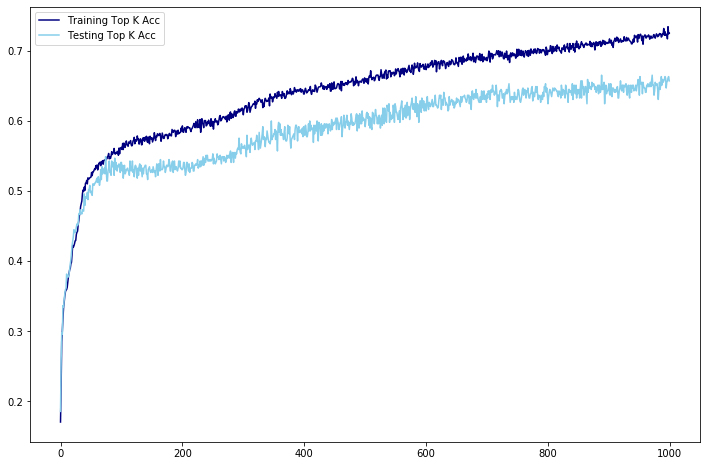

In [150]:
train_loss = history.history['top_k_categorical_accuracy']
test_loss = history.history['val_top_k_categorical_accuracy']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Top K Acc', color='navy')
plt.plot(test_loss, label='Testing Top K Acc', color='skyblue')
plt.legend();

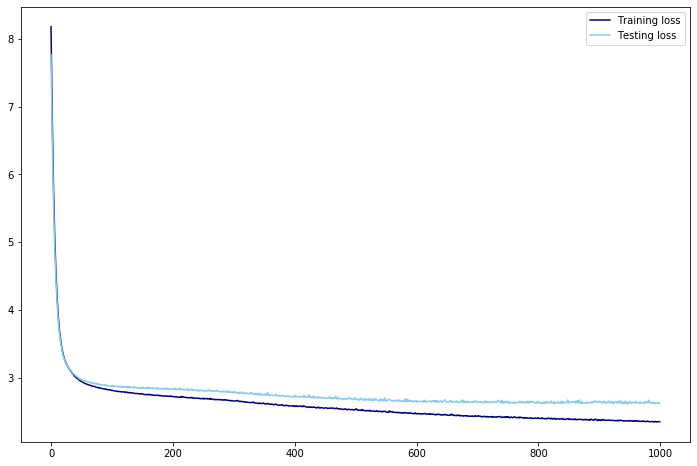

In [151]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

## Digging into the results

In [152]:
## Neural Network for Audio Features
from sklearn.metrics import classification_report

y_true = np.argmax(y_test, axis = 1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = list(encoder.categories_)

report = classification_report(y_true, y_pred, target_names=encoder.get_feature_names(), output_dict=True)

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [153]:
class_results = pd.DataFrame(report).T

In [154]:
print(classification_report(y_true, y_pred, target_names=encoder.get_feature_names()))

                       precision    recall  f1-score   support

        x0_9th Wonder       0.06      0.06      0.06        17
         x0_Ant Banks       0.22      0.40      0.29        10
        x0_Black Milk       0.00      0.00      0.00        10
          x0_Buckwild       0.25      0.05      0.08        20
        x0_DJ Premier       0.29      0.24      0.26        29
           x0_DJ Quik       0.36      0.23      0.28        22
     x0_Daz Dillinger       0.00      0.00      0.00         8
      x0_Erick Sermon       0.17      0.18      0.17        22
      x0_Flying Lotus       0.60      0.94      0.73        16
             x0_GAWVI       0.20      0.08      0.11        13
        x0_J.J. Brown       0.00      0.00      0.00         8
        x0_Just Blaze       0.11      0.09      0.10        11
        x0_Kanye West       0.00      0.00      0.00        18
            x0_Madlib       0.00      0.00      0.00        16
      x0_Mannie Fresh       0.33      0.05      0.09  

In [155]:
class_results.shape

(32, 4)

In [157]:
class_results = class_results[:29]
class_results = class_results[class_results['f1-score'] > 0]
class_results.index = class_results.index.str.replace('x0_', '')
class_results = class_results.sort_values(by='f1-score')

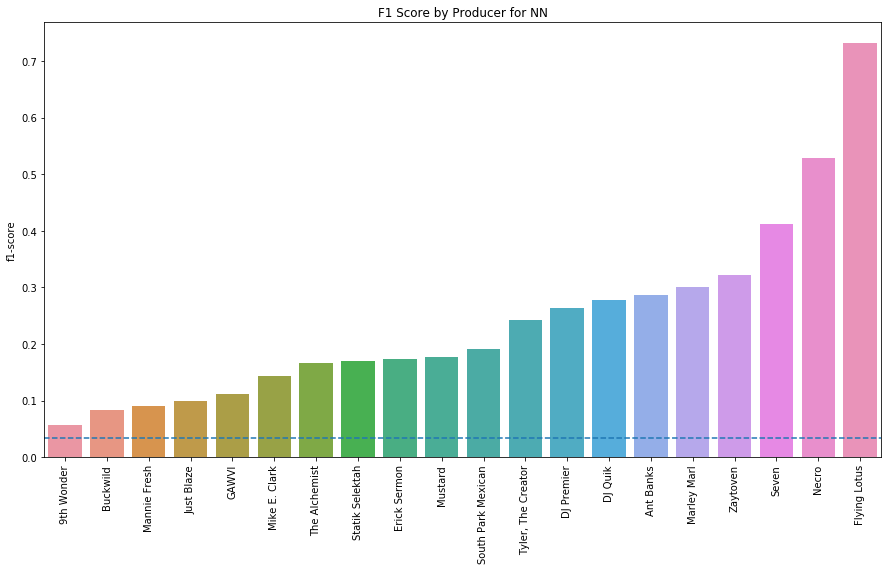

In [158]:
plt.figure(figsize=(15,8))
sns.barplot(x=class_results.index, y="f1-score", data=class_results);
plt.xticks(rotation=90);
plt.axhline(.034, ls='--');
plt.title('F1 Score by Producer for NN');


Flying Lotus showed a significantly better F1 score than the remaining producers. I know from my knowledge of the genre that Flying Lotus is often instrumental driven with little vocals on the track. Is this what's happening here? Lets compare to Kanye and the overall dataframe.

#### Speechiness

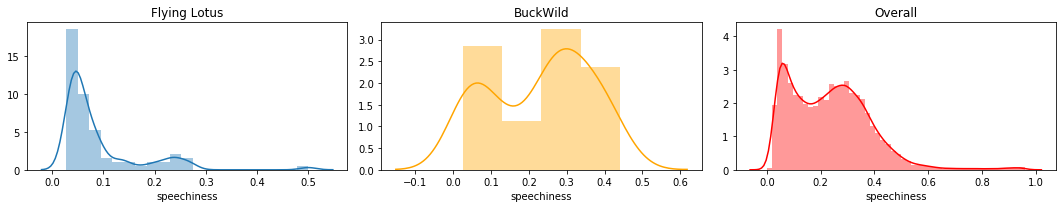

In [190]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
sns.distplot(df_all.loc[df_all.artist_clean.str.contains('lotus'), 'speechiness']);
plt.title('Flying Lotus')
plt.subplot(1,3,2)
sns.distplot(df_all.loc[df_all.producers.str.contains('Buckwild'), 'speechiness'], color='orange');
plt.title('BuckWild')
plt.subplot(1,3,3)
sns.distplot(df_all.speechiness, color='red');## Digging into the results
plt.title('Overall')
plt.tight_layout()

#### Total Words

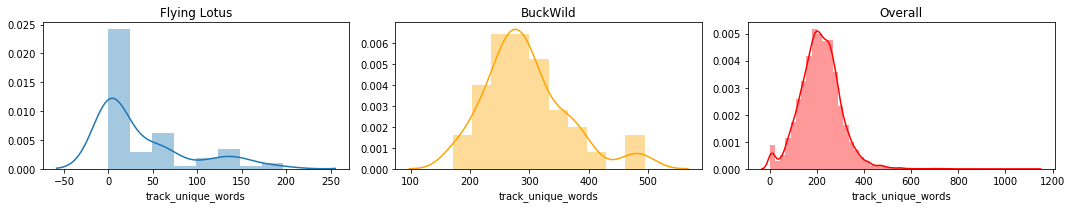

In [192]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
sns.distplot(df_all.loc[df_all.artist_clean.str.contains('lotus'), 'track_unique_words']);
plt.title('Flying Lotus')
plt.subplot(1,3,2)
sns.distplot(df_all.loc[df_all.producers.str.contains('Buckwild'), 'track_unique_words'], color='orange');
plt.title('BuckWild')
plt.subplot(1,3,3)
sns.distplot(df_all.track_unique_words, color='red');
plt.title('Overall')
plt.tight_layout()

It does appears to the be the case -- the distribution of Speechiness and total word counts at the track level for flying Lotus is much lower. I'm now going to see if I can remove vocals from our test/train set.

To do this, we'll leverage a little trick with audio. If you isolate to the left stereo, followed by the right stero, and recompile our audio file, you will strip out the center of the track, which is typically home to the vocals.

***
## Replicating with Vocals Removed

In [161]:
df_novoc =df_all
df_novoc.producers = df_novoc.producers.str.replace('[','').str.replace(']','').str.replace("'",'')
df_novoc = df_novoc[['producers','danceability', 'energy','acousticness',
         'instrumentalness','key', 'liveness', 'loudness', 'tempo_y',
        'chroma_stft', 'spec_cent', 'spec_bw', 'rolloff', 'zcr', 'mfcc', 'librosa_id', 'preview_url']]
df_novoc = df_novoc[df_novoc.producers.isin(top_prod)]

In [162]:
df_novoc.librosa_id[19]

'0FtsMKmZEq8fBWqdSOWtqp_4idSpCksSGx8lXtY4nHS8d_2A7yRfAp9RNFOUCGzurAyp'

In [38]:
import urllib
import urllib.request
import requests
from urllib import request

for index, row in df_novoc.iterrows():
    preview_url = str(row['preview_url'])
    librosa_id = str(row['librosa_id'])

    urllib.request.urlretrieve(preview_url,'D:/song_snippets_novoc/' 
                            +librosa_id + '.mp3')

### Strip out Vocals

In [67]:
#read in audio file and get the two mono tracks
librosa_ids = []
tempo= []
chroma_stft = []
spec_cent =[]
spec_bw = []
rolloff = []
zcr = []
mfcc = []
    
load_directory = 'D:/song_snippets_novoc/'
write_directory = 'D:/song_snippets_novoc/removed/'

for filename in os.listdir(load_directory):
    print(zcr)
    
    librosa_ids.append(filename)
    sound_stereo = AudioSegment.from_file(load_directory + filename, format="mp3")
    sound_monoL = sound_stereo.split_to_mono()[0]
    sound_monoR = sound_stereo.split_to_mono()[1]

    # Invert phase of the Right audio file
    sound_monoR_inv = sound_monoR.invert_phase()

    # Merge two L and R_inv files, this cancels out the centers
    sound_CentersOut = sound_monoL.overlay(sound_monoR_inv)

    # Export merged audio file
    fh = sound_CentersOut.export(write_directory + filename, format="mp3")

    try:
        y,sr  = librosa.load(write_directory + filename)
    except:
        pass

    try:
        tempo.append(np.mean(librosa.beat.tempo(onset_envelope=onset_env, sr=sr))) 
    except:
        tempo.append(0) 
    try:   
        chroma_stft.append(np.mean(librosa.feature.chroma_stft(y=y, sr=sr)))  
    except:
        chroma_stft.append(0)
    try:   
        spec_cent.append(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))) 
    except:
        spec_cent.append(0) 
    try:           
        spec_bw.append(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))
    except:
        spec_bw.append(0)
    try:           
        rolloff.append(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))
    except:
        rolloff.append(0)
    try:           
        zcr.append(np.mean(librosa.feature.zero_crossing_rate(y)))
    except:
        zcr.append(0)  
    try:           
        mfcc.append(np.mean(librosa.feature.mfcc(y=y, sr=sr)))
    except:
        mfcc.append(0)

In [70]:
temp_audio_features_df = pd.DataFrame(zip(librosa_ids, tempo, chroma_stft, spec_cent, spec_bw, rolloff, zcr, mfcc))
temp_audio_features_df.columns = ['librosa_id', 'tempo', 'chroma_stft', 'spec_cent', 'spec_bw', 'rolloff', 'zcr', 'mfcc']

In [89]:
df_novoc = df_novoc.drop(columns=['tempo_y',
       'chroma_stft', 'spec_cent', 'spec_bw', 'rolloff', 'zcr', 'mfcc',
       'preview_url'])

In [126]:
temp_audio_features_df.librosa_id = temp_audio_features_df.librosa_id[0][:-4]

In [100]:
df_novoc = pd.merge(df_novoc, temp_audio_features_df, on='librosa_id')

In [130]:
df_novoc.to_csv('novocaltrainingset.csv',index=False)

In [164]:
df_novoc = pd.read_csv('novocaltrainingset.csv')

In [171]:
df_novoc.tempo = df_novoc.tempo.fillna(np.mean(df_novoc.tempo))
df_novoc.chroma_stft = df_novoc.chroma_stft.fillna(np.mean(df_novoc.chroma_stft))
df_novoc.spec_cent = df_novoc.spec_cent.fillna(np.mean(df_novoc.spec_cent))
df_novoc.spec_bw = df_novoc.spec_bw.fillna(np.mean(df_novoc.spec_bw))
df_novoc.rolloff = df_novoc.rolloff.fillna(np.mean(df_novoc.rolloff))
df_novoc.zcr = df_novoc.zcr.fillna(np.mean(df_novoc.zcr))
df_novoc.mfcc = df_novoc.mfcc.fillna(np.mean(df_novoc.mfcc))


prod_list_novoc = df_novoc.producers
encoder = OneHotEncoder()
y_novoc = encoder.fit_transform(np.array(prod_list).reshape(-1, 1))

In [172]:
prod_list_novoc.shape

(2448,)

In [173]:
y_novoc.shape

(2448, 29)

In [174]:
X_novoc = df_novoc.drop(columns=['librosa_id', 'producers'])

In [175]:
scaler = StandardScaler()
X_novoc = scaler.fit_transform(X_novoc)

## Train Test Split

In [176]:
X_train_novoc, X_test_novoc, y_train_novoc, y_test_novoc = train_test_split(X_novoc, y_novoc, test_size=0.2)

In [177]:
X_train_novoc.shape

(1958, 14)

In [178]:
y_novoc.shape

(2448, 29)

In [179]:
y_train.shape

(1958, 29)

## Neural Network for Audio Features

In [180]:
model_novoc = models.Sequential()
model_novoc.add(layers.Dense(16, activation='relu', input_shape=(X_train_novoc.shape[1],)))
model_novoc.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model_novoc.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model_novoc.add(layers.Dense(29, activation='softmax'))

In [181]:
model_novoc.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [182]:
history = model_novoc.fit(X_train_novoc,
                    y_train_novoc,
                    epochs=1000,
                    batch_size=128,
                    validation_data=(X_test_novoc, y_test_novoc))

Train on 1958 samples, validate on 490 samples
Epoch 1/1000
1958/1958 [==============================] - 0s 68us/step - loss: 8.3420 - accuracy: 0.0378 - top_k_categorical_accuracy: 0.1655 - val_loss: 7.9374 - val_accuracy: 0.0510 - val_top_k_categorical_accuracy: 0.2224
Epoch 2/1000
1958/1958 [==============================] - 0s 16us/step - loss: 7.6304 - accuracy: 0.0582 - top_k_categorical_accuracy: 0.2334 - val_loss: 7.2776 - val_accuracy: 0.0673 - val_top_k_categorical_accuracy: 0.2510
Epoch 3/1000
1958/1958 [==============================] - 0s 16us/step - loss: 7.0085 - accuracy: 0.0858 - top_k_categorical_accuracy: 0.2707 - val_loss: 6.7048 - val_accuracy: 0.0755 - val_top_k_categorical_accuracy: 0.2612
Epoch 4/1000
1958/1958 [==============================] - 0s 17us/step - loss: 6.4701 - accuracy: 0.0909 - top_k_categorical_accuracy: 0.2962 - val_loss: 6.2096 - val_accuracy: 0.0694 - val_top_k_categorical_accuracy: 0.2857
Epoch 5/1000
1958/1958 [=============================

1958/1958 [==============================] - 0s 17us/step - loss: 3.2820 - accuracy: 0.0986 - top_k_categorical_accuracy: 0.3202 - val_loss: 3.3076 - val_accuracy: 0.0796 - val_top_k_categorical_accuracy: 0.2857
Epoch 73/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.2813 - accuracy: 0.0986 - top_k_categorical_accuracy: 0.3141 - val_loss: 3.3086 - val_accuracy: 0.0816 - val_top_k_categorical_accuracy: 0.2816
Epoch 74/1000
1958/1958 [==============================] - 0s 17us/step - loss: 3.2805 - accuracy: 0.0986 - top_k_categorical_accuracy: 0.3156 - val_loss: 3.3082 - val_accuracy: 0.0796 - val_top_k_categorical_accuracy: 0.2796
Epoch 75/1000
1958/1958 [==============================] - 0s 19us/step - loss: 3.2810 - accuracy: 0.0986 - top_k_categorical_accuracy: 0.3172 - val_loss: 3.3071 - val_accuracy: 0.0776 - val_top_k_categorical_accuracy: 0.2857
Epoch 76/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.2802 - accuracy: 0.0986 - to

Epoch 108/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.2737 - accuracy: 0.0986 - top_k_categorical_accuracy: 0.3182 - val_loss: 3.3036 - val_accuracy: 0.0837 - val_top_k_categorical_accuracy: 0.2857
Epoch 109/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.2744 - accuracy: 0.0986 - top_k_categorical_accuracy: 0.3192 - val_loss: 3.3025 - val_accuracy: 0.0837 - val_top_k_categorical_accuracy: 0.2959
Epoch 110/1000
1958/1958 [==============================] - 0s 17us/step - loss: 3.2742 - accuracy: 0.0975 - top_k_categorical_accuracy: 0.3166 - val_loss: 3.3043 - val_accuracy: 0.0837 - val_top_k_categorical_accuracy: 0.2918
Epoch 111/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.2738 - accuracy: 0.0970 - top_k_categorical_accuracy: 0.3126 - val_loss: 3.3050 - val_accuracy: 0.0837 - val_top_k_categorical_accuracy: 0.2939
Epoch 112/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.2740 - ac

Epoch 144/1000
1958/1958 [==============================] - 0s 17us/step - loss: 3.2695 - accuracy: 0.0960 - top_k_categorical_accuracy: 0.3121 - val_loss: 3.3016 - val_accuracy: 0.0857 - val_top_k_categorical_accuracy: 0.3000
Epoch 145/1000
1958/1958 [==============================] - 0s 17us/step - loss: 3.2693 - accuracy: 0.0970 - top_k_categorical_accuracy: 0.3207 - val_loss: 3.3013 - val_accuracy: 0.0857 - val_top_k_categorical_accuracy: 0.2980
Epoch 146/1000
1958/1958 [==============================] - 0s 17us/step - loss: 3.2699 - accuracy: 0.0965 - top_k_categorical_accuracy: 0.3146 - val_loss: 3.3018 - val_accuracy: 0.0796 - val_top_k_categorical_accuracy: 0.3020
Epoch 147/1000
1958/1958 [==============================] - 0s 17us/step - loss: 3.2691 - accuracy: 0.0975 - top_k_categorical_accuracy: 0.3085 - val_loss: 3.3026 - val_accuracy: 0.0857 - val_top_k_categorical_accuracy: 0.2980
Epoch 148/1000
1958/1958 [==============================] - ETA: 0s - loss: 3.2536 - accurac

Epoch 180/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.2665 - accuracy: 0.0970 - top_k_categorical_accuracy: 0.3105 - val_loss: 3.3015 - val_accuracy: 0.0796 - val_top_k_categorical_accuracy: 0.3020
Epoch 181/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.2664 - accuracy: 0.0970 - top_k_categorical_accuracy: 0.3121 - val_loss: 3.3031 - val_accuracy: 0.0816 - val_top_k_categorical_accuracy: 0.2959
Epoch 182/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.2668 - accuracy: 0.0975 - top_k_categorical_accuracy: 0.3126 - val_loss: 3.3046 - val_accuracy: 0.0796 - val_top_k_categorical_accuracy: 0.2918
Epoch 183/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.2660 - accuracy: 0.0975 - top_k_categorical_accuracy: 0.3126 - val_loss: 3.3000 - val_accuracy: 0.0796 - val_top_k_categorical_accuracy: 0.2939
Epoch 184/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.2649 - ac

1958/1958 [==============================] - 0s 15us/step - loss: 3.2601 - accuracy: 0.0970 - top_k_categorical_accuracy: 0.3156 - val_loss: 3.3033 - val_accuracy: 0.0796 - val_top_k_categorical_accuracy: 0.2980
Epoch 253/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.2597 - accuracy: 0.0970 - top_k_categorical_accuracy: 0.3177 - val_loss: 3.3043 - val_accuracy: 0.0796 - val_top_k_categorical_accuracy: 0.3041
Epoch 254/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.2595 - accuracy: 0.0975 - top_k_categorical_accuracy: 0.3161 - val_loss: 3.3015 - val_accuracy: 0.0796 - val_top_k_categorical_accuracy: 0.3061
Epoch 255/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.2591 - accuracy: 0.0981 - top_k_categorical_accuracy: 0.3100 - val_loss: 3.3027 - val_accuracy: 0.0796 - val_top_k_categorical_accuracy: 0.3000
Epoch 256/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.2592 - accuracy: 0.0981 

1958/1958 [==============================] - 0s 14us/step - loss: 3.2535 - accuracy: 0.0996 - top_k_categorical_accuracy: 0.3136 - val_loss: 3.3037 - val_accuracy: 0.0776 - val_top_k_categorical_accuracy: 0.3041
Epoch 325/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.2537 - accuracy: 0.0996 - top_k_categorical_accuracy: 0.3156 - val_loss: 3.3000 - val_accuracy: 0.0776 - val_top_k_categorical_accuracy: 0.2980
Epoch 326/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.2534 - accuracy: 0.1006 - top_k_categorical_accuracy: 0.3182 - val_loss: 3.3030 - val_accuracy: 0.0776 - val_top_k_categorical_accuracy: 0.2959
Epoch 327/1000
1958/1958 [==============================] - 0s 13us/step - loss: 3.2530 - accuracy: 0.0996 - top_k_categorical_accuracy: 0.3187 - val_loss: 3.3021 - val_accuracy: 0.0755 - val_top_k_categorical_accuracy: 0.3041
Epoch 328/1000
1958/1958 [==============================] - ETA: 0s - loss: 3.2985 - accuracy: 0.0859 - top

Epoch 360/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.2499 - accuracy: 0.0986 - top_k_categorical_accuracy: 0.3202 - val_loss: 3.3009 - val_accuracy: 0.0735 - val_top_k_categorical_accuracy: 0.3000
Epoch 361/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.2506 - accuracy: 0.0981 - top_k_categorical_accuracy: 0.3238 - val_loss: 3.2996 - val_accuracy: 0.0735 - val_top_k_categorical_accuracy: 0.3020
Epoch 362/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.2502 - accuracy: 0.0991 - top_k_categorical_accuracy: 0.3192 - val_loss: 3.2983 - val_accuracy: 0.0714 - val_top_k_categorical_accuracy: 0.2959
Epoch 363/1000
1958/1958 [==============================] - 0s 18us/step - loss: 3.2507 - accuracy: 0.0970 - top_k_categorical_accuracy: 0.3182 - val_loss: 3.2997 - val_accuracy: 0.0735 - val_top_k_categorical_accuracy: 0.3000
Epoch 364/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.2495 - ac

1958/1958 [==============================] - 0s 13us/step - loss: 3.2413 - accuracy: 0.1011 - top_k_categorical_accuracy: 0.3355 - val_loss: 3.2900 - val_accuracy: 0.0735 - val_top_k_categorical_accuracy: 0.2898
Epoch 433/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.2416 - accuracy: 0.0991 - top_k_categorical_accuracy: 0.3371 - val_loss: 3.2910 - val_accuracy: 0.0755 - val_top_k_categorical_accuracy: 0.2939
Epoch 434/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.2403 - accuracy: 0.0986 - top_k_categorical_accuracy: 0.3371 - val_loss: 3.2892 - val_accuracy: 0.0735 - val_top_k_categorical_accuracy: 0.2918
Epoch 435/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.2425 - accuracy: 0.0981 - top_k_categorical_accuracy: 0.3371 - val_loss: 3.2903 - val_accuracy: 0.0735 - val_top_k_categorical_accuracy: 0.3000
Epoch 436/1000
1958/1958 [==============================] - 0s 13us/step - loss: 3.2396 - accuracy: 0.0986 

1958/1958 [==============================] - 0s 14us/step - loss: 3.2326 - accuracy: 0.0970 - top_k_categorical_accuracy: 0.3447 - val_loss: 3.2809 - val_accuracy: 0.0755 - val_top_k_categorical_accuracy: 0.2959
Epoch 505/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.2322 - accuracy: 0.0965 - top_k_categorical_accuracy: 0.3432 - val_loss: 3.2854 - val_accuracy: 0.0755 - val_top_k_categorical_accuracy: 0.2857
Epoch 506/1000
1958/1958 [==============================] - 0s 17us/step - loss: 3.2324 - accuracy: 0.0986 - top_k_categorical_accuracy: 0.3442 - val_loss: 3.2850 - val_accuracy: 0.0735 - val_top_k_categorical_accuracy: 0.2918
Epoch 507/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.2322 - accuracy: 0.0960 - top_k_categorical_accuracy: 0.3488 - val_loss: 3.2788 - val_accuracy: 0.0776 - val_top_k_categorical_accuracy: 0.2959
Epoch 508/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.2326 - accuracy: 0.0955 

1958/1958 [==============================] - 0s 14us/step - loss: 3.2234 - accuracy: 0.1006 - top_k_categorical_accuracy: 0.3524 - val_loss: 3.2818 - val_accuracy: 0.0776 - val_top_k_categorical_accuracy: 0.3000
Epoch 577/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.2243 - accuracy: 0.0996 - top_k_categorical_accuracy: 0.3509 - val_loss: 3.2803 - val_accuracy: 0.0755 - val_top_k_categorical_accuracy: 0.2980
Epoch 578/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.2226 - accuracy: 0.1001 - top_k_categorical_accuracy: 0.3524 - val_loss: 3.2877 - val_accuracy: 0.0816 - val_top_k_categorical_accuracy: 0.2959
Epoch 579/1000
1958/1958 [==============================] - 0s 13us/step - loss: 3.2248 - accuracy: 0.1011 - top_k_categorical_accuracy: 0.3534 - val_loss: 3.2884 - val_accuracy: 0.0776 - val_top_k_categorical_accuracy: 0.3041
Epoch 580/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.2242 - accuracy: 0.0970 

1958/1958 [==============================] - 0s 14us/step - loss: 3.2147 - accuracy: 0.1052 - top_k_categorical_accuracy: 0.3601 - val_loss: 3.2875 - val_accuracy: 0.0776 - val_top_k_categorical_accuracy: 0.3041
Epoch 649/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.2139 - accuracy: 0.1083 - top_k_categorical_accuracy: 0.3611 - val_loss: 3.2821 - val_accuracy: 0.0796 - val_top_k_categorical_accuracy: 0.3041
Epoch 650/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.2121 - accuracy: 0.1083 - top_k_categorical_accuracy: 0.3565 - val_loss: 3.2813 - val_accuracy: 0.0796 - val_top_k_categorical_accuracy: 0.3000
Epoch 651/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.2139 - accuracy: 0.1057 - top_k_categorical_accuracy: 0.3580 - val_loss: 3.2849 - val_accuracy: 0.0816 - val_top_k_categorical_accuracy: 0.3061
Epoch 652/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.2107 - accuracy: 0.1078 

Epoch 720/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.2003 - accuracy: 0.1052 - top_k_categorical_accuracy: 0.3723 - val_loss: 3.2786 - val_accuracy: 0.0857 - val_top_k_categorical_accuracy: 0.3184
Epoch 721/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.1987 - accuracy: 0.1052 - top_k_categorical_accuracy: 0.3657 - val_loss: 3.2798 - val_accuracy: 0.0878 - val_top_k_categorical_accuracy: 0.2980
Epoch 722/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.1996 - accuracy: 0.1073 - top_k_categorical_accuracy: 0.3662 - val_loss: 3.2863 - val_accuracy: 0.0857 - val_top_k_categorical_accuracy: 0.3163
Epoch 723/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.2007 - accuracy: 0.1057 - top_k_categorical_accuracy: 0.3749 - val_loss: 3.2764 - val_accuracy: 0.0898 - val_top_k_categorical_accuracy: 0.3082
Epoch 724/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.1970 - ac

1958/1958 [==============================] - 0s 14us/step - loss: 3.1890 - accuracy: 0.1067 - top_k_categorical_accuracy: 0.3723 - val_loss: 3.2757 - val_accuracy: 0.0878 - val_top_k_categorical_accuracy: 0.3102
Epoch 793/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.1875 - accuracy: 0.1093 - top_k_categorical_accuracy: 0.3708 - val_loss: 3.2746 - val_accuracy: 0.0878 - val_top_k_categorical_accuracy: 0.3102
Epoch 794/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.1898 - accuracy: 0.1078 - top_k_categorical_accuracy: 0.3723 - val_loss: 3.2751 - val_accuracy: 0.0816 - val_top_k_categorical_accuracy: 0.3061
Epoch 795/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.1884 - accuracy: 0.1088 - top_k_categorical_accuracy: 0.3779 - val_loss: 3.2765 - val_accuracy: 0.0878 - val_top_k_categorical_accuracy: 0.3204
Epoch 796/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.1875 - accuracy: 0.1073 

Epoch 864/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.1829 - accuracy: 0.1103 - top_k_categorical_accuracy: 0.3779 - val_loss: 3.2741 - val_accuracy: 0.0857 - val_top_k_categorical_accuracy: 0.3061
Epoch 865/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.1817 - accuracy: 0.1052 - top_k_categorical_accuracy: 0.3713 - val_loss: 3.2734 - val_accuracy: 0.0796 - val_top_k_categorical_accuracy: 0.3245
Epoch 866/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.1828 - accuracy: 0.1062 - top_k_categorical_accuracy: 0.3861 - val_loss: 3.2751 - val_accuracy: 0.0857 - val_top_k_categorical_accuracy: 0.3306
Epoch 867/1000
1958/1958 [==============================] - 0s 13us/step - loss: 3.1814 - accuracy: 0.1093 - top_k_categorical_accuracy: 0.3749 - val_loss: 3.2723 - val_accuracy: 0.0816 - val_top_k_categorical_accuracy: 0.3265
Epoch 868/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.1798 - ac

Epoch 900/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.1794 - accuracy: 0.1062 - top_k_categorical_accuracy: 0.3825 - val_loss: 3.2722 - val_accuracy: 0.0857 - val_top_k_categorical_accuracy: 0.3184
Epoch 901/1000
1958/1958 [==============================] - 0s 14us/step - loss: 3.1777 - accuracy: 0.1124 - top_k_categorical_accuracy: 0.3790 - val_loss: 3.2714 - val_accuracy: 0.0816 - val_top_k_categorical_accuracy: 0.3184
Epoch 902/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.1798 - accuracy: 0.1042 - top_k_categorical_accuracy: 0.3810 - val_loss: 3.2772 - val_accuracy: 0.0837 - val_top_k_categorical_accuracy: 0.3102
Epoch 903/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.1814 - accuracy: 0.1093 - top_k_categorical_accuracy: 0.3754 - val_loss: 3.2738 - val_accuracy: 0.0816 - val_top_k_categorical_accuracy: 0.3224
Epoch 904/1000
1958/1958 [==============================] - 0s 15us/step - loss: 3.1770 - ac

1958/1958 [==============================] - 0s 16us/step - loss: 3.1752 - accuracy: 0.1057 - top_k_categorical_accuracy: 0.3784 - val_loss: 3.2750 - val_accuracy: 0.0837 - val_top_k_categorical_accuracy: 0.3163
Epoch 973/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.1715 - accuracy: 0.1052 - top_k_categorical_accuracy: 0.3902 - val_loss: 3.2729 - val_accuracy: 0.0816 - val_top_k_categorical_accuracy: 0.3184
Epoch 974/1000
1958/1958 [==============================] - 0s 17us/step - loss: 3.1727 - accuracy: 0.1118 - top_k_categorical_accuracy: 0.3749 - val_loss: 3.2737 - val_accuracy: 0.0816 - val_top_k_categorical_accuracy: 0.3163
Epoch 975/1000
1958/1958 [==============================] - 0s 16us/step - loss: 3.1759 - accuracy: 0.1118 - top_k_categorical_accuracy: 0.3856 - val_loss: 3.2729 - val_accuracy: 0.0837 - val_top_k_categorical_accuracy: 0.3163
Epoch 976/1000
1958/1958 [==============================] - 0s 17us/step - loss: 3.1754 - accuracy: 0.1088 

This approach was ineffective-- this can likely be tied back to audio loss beyond just vocals being removed from the track

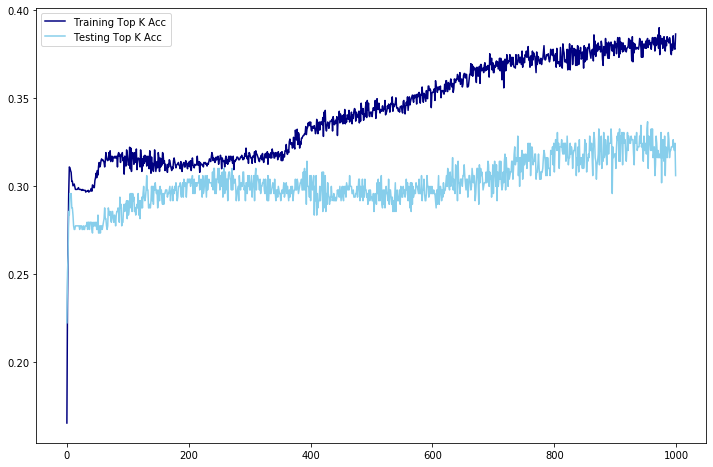

In [183]:
train_loss = history.history['top_k_categorical_accuracy']
test_loss = history.history['val_top_k_categorical_accuracy']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Top K Acc', color='navy')
plt.plot(test_loss, label='Testing Top K Acc', color='skyblue')
plt.legend();

# TBD: CNN And Mel Spectrograms

### Import

In [ ]:
import hickle as hk

In [ ]:
mels = hk.load("D:/mels.hkl")

In [ ]:
df_all.producers = df_all.producers.str.replace('[','').str.replace(']','').str.replace("'",'')

In [ ]:
df_all = df_all[df_all.producers.isin(top_prod)]

In [ ]:
df_all['librosa_id'] = df_all['artist_id'] + "_" + df_all['album_id'] + "_" +  df_all['track_id'] +'.mp3'

In [ ]:
df_all['librosa_id'][19]

In [ ]:
y,sr  = librosa.load('D:/song_snippets/00fUxTsDQ3TMlro9Abk6bG_0nbJXTbwfQ7WoY16uMSFia_184QicpUhkS9eh7mngmKtY' + '.mp3')
spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
spect = librosa.power_to_db(spect, ref=np.max)

In [ ]:
spect

In [ ]:
spect.T.shape

### Check Mel

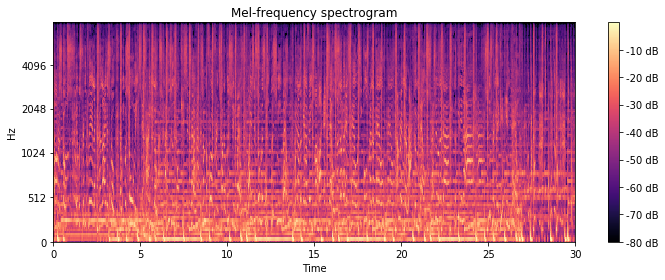

In [686]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(spect, x_axis='time',
                            y_axis='mel', sr=sr,
                           fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

**Understanding Mel Spectogram:**

128 = number of bins/frames of audio data

1292 = timeframes

### Decoding Medium Post

In [1111]:
spect.shape

(128, 1292)

In [1112]:
x_spect = np.empty((0,640,128))

In [1113]:
spect =  spect.T[:640,:]

In [1114]:
x_spect = np.append(x_spect, [spect], axis=0)

In [1115]:
x_spect.shape

(1, 640, 128)

In [1116]:
# np.log(librosa.core.db_to_power(x_spect, ref=1.0))

### Align Mel to Producer

In [543]:
mels_df = pd.DataFrame.from_dict(mels, orient='index').reset_index().rename(columns={'index':'librosa_id', 0:'mel'})

In [556]:
mels_df = pd.merge(df_all,mels_df, how='left', on='librosa_id')[['producers', 'mel']]

### Model

In [843]:
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D

In [844]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras import utils

In [1117]:
# X_mel = mels_df.mel
#y_mel = mels_df.producers
# encoder = LabelEncoder()
# y_mel = encoder.fit_transform(np.array(prod_list).reshape(-1, 1))

In [1118]:
# X_train_mel, X_test_mel, y_train_mel, y_test_mel = train_test_split(X_mel, y_mel, test_size=0.2)

In [1119]:
# X_mel.shape, X_train_mel.shape

### Medium